In [94]:
import json
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.style.use('seaborn-darkgrid')
%matplotlib inline

In [95]:
data = []
with open(os.path.join('data', 'train.json'), 'r') as train_file:
    for row in train_file:
        data.append(json.loads(row))

In [101]:
data_df = pd.DataFrame(data)
data_df

,overall,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image
0,4.0,"08 24, 2010",u04428712,"So is Katy Perry's new album ""Teenage Dream"" c...",Amazing that I Actually Bought This...More Ama...,1282608000,Pop,$35.93,p70761125,85559980,NaN
1,5.0,"10 31, 2009",u06946603,"I got this CD almost 10 years ago, and given t...",Excellent album,1256947200,Alternative Rock,$11.28,p85427891,41699565,NaN
2,4.0,"10 13, 2015",u92735614,I REALLY enjoy this pairing of Anderson and Po...,"Love the Music, Hate the Light Show",1444694400,Pop,$89.86,p82172532,24751194,NaN
3,5.0,"06 28, 2017",u35112935,Finally got it . It was everything thought it ...,Great,1498608000,Pop,$11.89,p15255251,22820631,NaN
4,4.0,"10 12, 2015",u07141505,"Look at all star cast. Outstanding record, pl...",Love these guys.,1444608000,Jazz,$15.24,p82618188,53377470,NaN
...,...,...,...,...,...,...,...,...,...,...,...
199995,4.0,"05 1, 2004",u68902609,"With this, Mariah's third album, Mariah proved...",Well Done Mariah! You Show 'Em!,1083369600,Pop,$7.98,p84118731,35077372,NaN
199996,5.0,"02 27, 2017",u15269603,Fantastic CD. All the hits are here and even ...,"Great collection, excellent sound!",1488153600,Pop,$11.49,p08613950,09788722,NaN
199997,3.0,"03 1, 2011",u25124021,"This recording is rather disappointing, to a c...",Odd Couplings,1298937600,Classical,$13.57,p25341819,71627957,NaN
199998,5.0,"03 20, 2016",u04485604,Get it now ! Right now ! I am partial. I am a ...,Our Poet,1458432000,Alternative Rock,$11.07,p19134748,27463540,NaN


In [102]:
from datetime import datetime

def trim_price(price):
    if (not pd.isnull(price) and isinstance(price, str) and
        len(price) > 0 and price[0] == '$'):
        return price[1:]
    return ""


data_df['reviewMonth'] = data_df['reviewTime'].apply(lambda x: x.split(' ')[0])
data_df['reviewYear'] = data_df['reviewTime'].apply(lambda x: x.split(' ')[2])
data_df['reviewHour'] = data_df['unixReviewTime'].apply(lambda x: datetime.fromtimestamp(x).hour)
data_df['reviewMonthYear'] = data_df['reviewYear'] + '-' + data_df['reviewMonth']
data_df['cleaned_price'] = data_df['price'].apply(lambda x: trim_price(x))
data_df = data_df[data_df['cleaned_price'] != ""]
data_df['cleaned_price'] = data_df['cleaned_price'].astype('float')

analysis_df = data_df.sort_values(by=['reviewYear', 'reviewMonth'])

<ipython-input-102-0ad7ebe8f8df>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['cleaned_price'] = data_df['cleaned_price'].astype('float')


### Looking at average rating by Month

Average rating seems to be consistently high suggesting users usually rate products quite highly.
The ends of the graph are not as relevant as they have very few ratings associated with the given month.

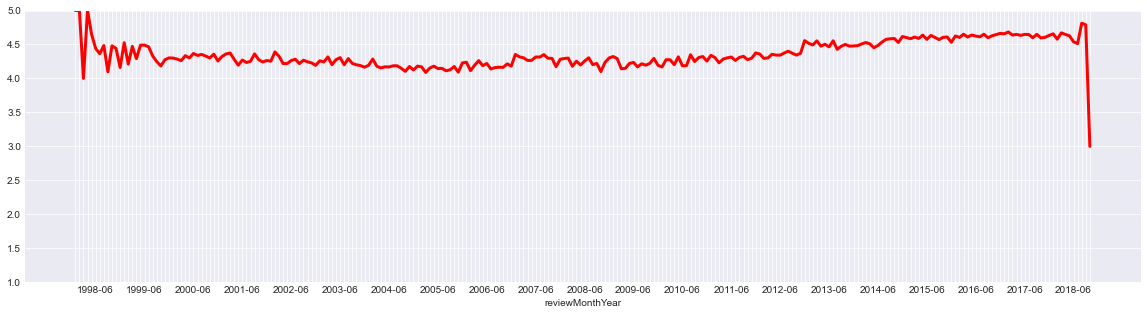

In [103]:
grouped_date = analysis_df.groupby(analysis_df['reviewMonthYear'])['overall'].mean()
tick_labels = [x if x[-2:] == '06' else '' for x in grouped_date.index]

plt.figure(figsize=(20,5))
grouped_date.plot(color='red', linewidth=3)
plt.xticks(range(len(tick_labels)), tick_labels)
plt.ylim(1, 5)
plt.show()

### Looking at Average Rating by User

This graph has a lot more variance, suggesting that average rating can be very different across users

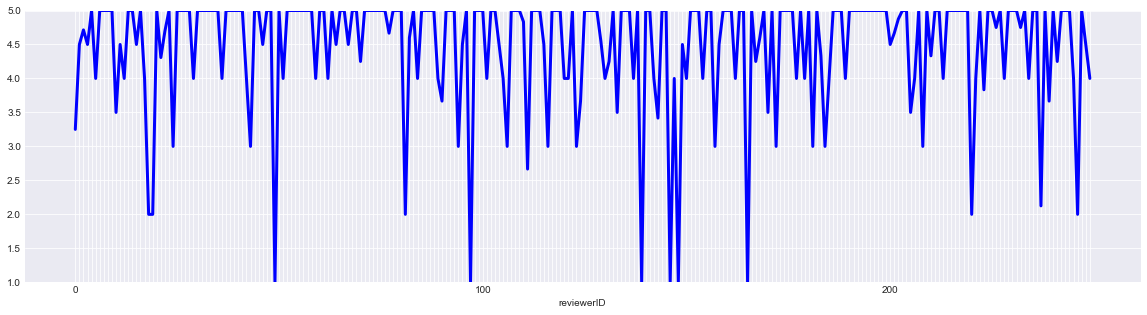

In [104]:
grouped_user = analysis_df.groupby(analysis_df['reviewerID'])['overall'].mean()
np.random.shuffle(grouped_user)
grouped_user = grouped_user[0:250]
tick_labels = [str(i) if i % 100 == 0 else '' for i in range(len(grouped_user.index))]

plt.figure(figsize=(20, 5))
grouped_user.plot(color='blue', linewidth=3)
plt.xticks(range(len(tick_labels)), tick_labels)
plt.ylim(1, 5)
plt.show()

### Looking at Average Rating by Item

Again, this graph has higher variance with different average ratings across items.

Combining this with the interpretation of the previous graph suggests that our model should combine features of both the item and the user (collaborative filtering)

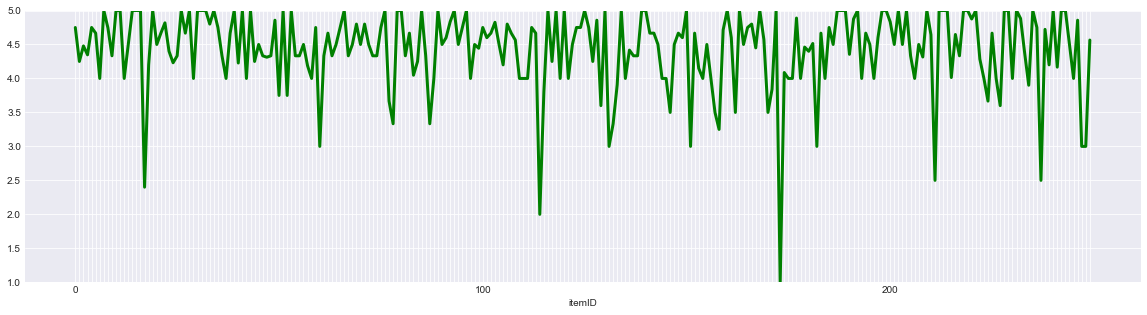

In [105]:
grouped_item = analysis_df.groupby(analysis_df['itemID'])['overall'].mean()
np.random.shuffle(grouped_item)
grouped_item = grouped_item[0:250]
tick_labels = [str(i) if i % 100 == 0 else '' for i in range(len(grouped_item.index))]

plt.figure(figsize=(20, 5))
grouped_item.plot(color='green', linewidth=3)
plt.xticks(range(len(tick_labels)), tick_labels)
plt.ylim(1, 5)
plt.show()

### Average Rating by Category

Average ratings are consistently high across the 5 categories with only a slight variance which may suggest that the feature will not have a large effect on the model.

However, it still may play a role per user (for example a user who consistently rates Alternative Rock highly may give a lower rating to Pop)

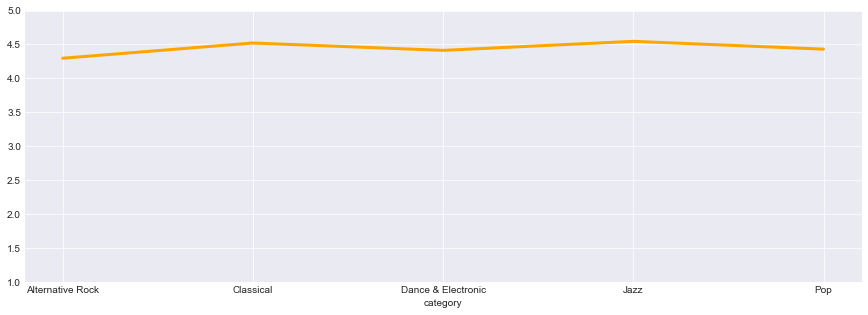

In [106]:
grouped_type_average = analysis_df.groupby(analysis_df['category'])['overall'].mean()

plt.figure(figsize=(15, 5))
grouped_type_average.plot(color='orange', linewidth=3)
plt.xticks(range(5), grouped_type_average.index)
plt.ylim(1, 5)
plt.show()

### Counting Ratings by Category

Pop is by far the most popular music category in this dataset. This graph suggests some considerating should be taken to ensure the validation set also matches these proportions.

In addition, some type of bootstrapping may be needed to balance the different categories when fitting a model

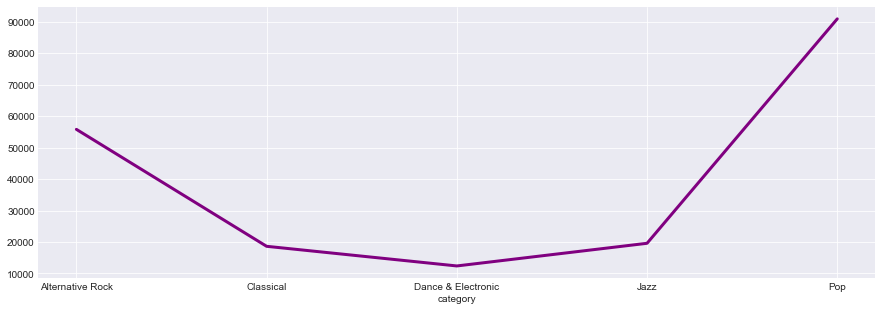

In [107]:
grouped_type_count = analysis_df.groupby(analysis_df['category'])['overall'].count()

plt.figure(figsize=(15, 5))
grouped_type_count.plot(color='purple', linewidth=3)
plt.xticks(range(5), grouped_type_average.index)
plt.show()

### Looking at a few Super Users

A super user is someone who has a lot of ratings in the dataset.

Want to see if they rate differently than the average and if they rate differently across different categories

In [132]:
grouped_user_count = analysis_df.groupby(analysis_df['reviewerID'])['overall'].count()
grouped_user_count = grouped_user_count.sort_values()
super_users = grouped_user_count.index[-20:]

There is a slight difference between the average rating by the super users and the rest of the users

In [135]:
super_data = analysis_df[analysis_df['reviewerID'].isin(super_users)]
non_super_data = analysis_df[~analysis_df['reviewerID'].isin(super_users)]

super_mean = super_data['overall'].mean()
non_super_mean = non_super_data['overall'].mean()

print("Super mean: {}".format(super_mean))
print("Non super mean: {}".format(non_super_mean))

Super mean: 4.235046521931768
Non super mean: 4.416388679930482


This mostly confirms the hypothesis that users seem to rate differently across category.

So, although category alone does not seem to be a strong predictor of rating, category for a particular person seems to have higher discriminating power when it comes to rating

In [147]:
import sys
np.set_printoptions(threshold=sys.maxsize)

super_data['userAndCategory'] = super_data['reviewerID'] + '-' + super_data['category']
grouped_user_category = super_data.groupby(super_data['userAndCategory'])['overall'].mean()
indices = grouped_user_category.index.sort_values()
grouped_user_category = grouped_user_category[indices]
grouped_user_category = pd.DataFrame({'userAndCategory': grouped_user_category.index,
                                      'averageRating': grouped_user_category.values})
grouped_user_category['user'] = grouped_user_category['userAndCategory'].apply(lambda x: x.split("-")[0])
for super_user in super_users:
    print(super_user)
    print("---------")
    print(grouped_user_category[grouped_user_category['user'] == super_user][['userAndCategory', 'averageRating']])
    print()

u83618720
---------
        userAndCategory  averageRating
64  u83618720-Classical       4.921986
65       u83618720-Jazz       5.000000

u30320873
---------
                 userAndCategory  averageRating
20    u30320873-Alternative Rock       4.888889
21           u30320873-Classical       5.000000
22  u30320873-Dance & Electronic       5.000000
23                u30320873-Jazz       5.000000
24                 u30320873-Pop       5.000000

u36062488
---------
        userAndCategory  averageRating
25  u36062488-Classical       5.000000
26       u36062488-Jazz       4.386139
27        u36062488-Pop       4.600000

u62086935
---------
                 userAndCategory  averageRating
55    u62086935-Alternative Rock       4.051724
56           u62086935-Classical       5.000000
57  u62086935-Dance & Electronic       4.000000
58                 u62086935-Pop       3.762887

u88592233
---------
                 userAndCategory  averageRating
69    u88592233-Alternative Rock       4.486111

<ipython-input-147-b92d33713022>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super_data['userAndCategory'] = super_data['reviewerID'] + '-' + super_data['category']


### Average Rating by Price

The average rating seems to be quite varied across different price points. However, it does seem that in the extreme, higher priced items have a higher rating

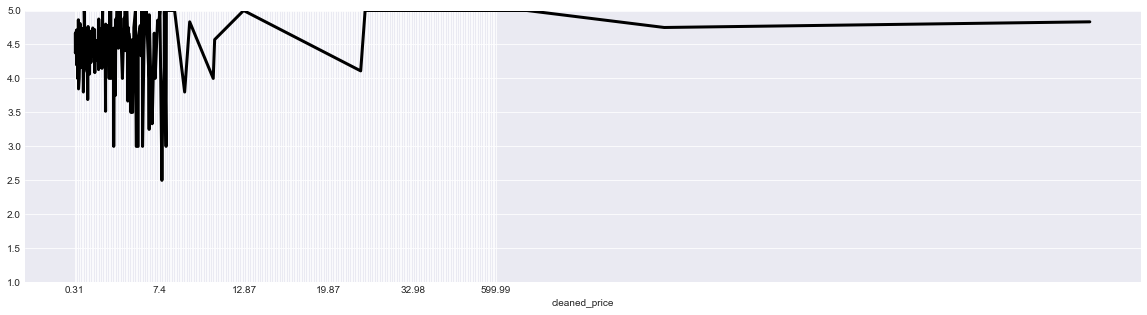

In [127]:
grouped_price = analysis_df.groupby(analysis_df['cleaned_price'])['overall'].mean()
indices = grouped_price.index[np.random.choice(range(len(grouped_price)), 250)].sort_values()
grouped_price = grouped_price[indices]
tick_labels = [str(grouped_price.index[i]) if i % 50 == 0 or i == 249 else "" for i in range(250)]

plt.figure(figsize=(20, 5))
grouped_price.plot(color='black', linewidth=3)
plt.xticks(range(len(tick_labels)), tick_labels)
plt.ylim(1, 5)
plt.show()